In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import tensorflow as tf
import tensorflow.keras as keras
from keras import layers, models, activations
from keras.models import Model
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
# CGP parameter configuration

# List of blocks
convset = ['ConvBlock32_3',
           'ConvBlock32_5',
           'ConvBlock64_3',
           'ConvBlock64_5',
           'ConvBlock128_3',
           'ConvBlock128_5',
           'pool_max',
           'pool_ave']

# List of how many inputs each block receives, indexes align with the blocks in convset
func_in_num = [1,
               1,
               1,
               1,
               1,
               1,
               1,
               1,
               1,
               1]

# If we want to try resset
resset = []

# CGP vars
input_num = 1 #number of input layers
out_num = 1 #number of output layers
out_type = ['full'] #types of output layers
out_in_num = [1] #number of inputs the output layer takes

# CGP grid configuration
rows = 1
cols = 50
node_num = rows * cols
level_back = 10 #how many layers back connections can be made
# window active nodes
#min_active_num = 10 
#max_active_num = 50

func_type_num = len(convset)
out_type_num = len(out_type)
max_in_num = np.max([np.max(func_in_num), np.max(out_in_num)])

In [3]:
# make np.array to use for first gene, parent
gene = np.zeros((node_num + out_num, max_in_num + 1)).astype(int)
print(gene)

[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]


In [4]:
# make np.array with bools to use which layers are active
is_active = np.empty(node_num + out_num).astype(bool)
print(is_active)

[ True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False]


In [5]:
# initialize parent gene
def init_gene():
    for n in range(node_num + out_num):
        # type gene
        type_num = func_type_num if n < node_num else out_type_num
        gene[n][0] = np.random.randint(type_num)
        # connection gene
        col = np.min((int(n / rows), cols))
        max_connect_id = col * rows + input_num
        min_connect_id = (col - level_back) * rows + input_num if col - level_back >= 0 else 0
        for i in range(max_in_num):
            gene[n][i + 1] = min_connect_id + np.random.randint(max_connect_id - min_connect_id)

In [6]:
# function to check if input connects to output, starts from output
def check_course_to_out(gene, is_active, n):
    if not is_active[n]:
        is_active[n] = True
        t = gene[n][0]
        if n >= node_num:    # output node
            in_num = out_in_num[t]
        else:    # intermediate node
            in_num = func_in_num[t]

        for i in range(in_num):
            if gene[n][i+1] >= input_num:
                check_course_to_out(gene, is_active, gene[n][i+1] - input_num)
        return is_active

In [7]:
# keep initializing first gene until one is found with an active input and output node
is_active[:] = False
first_layer_is_conv = False
while( not is_active[-1]  ): 
    is_active[:] = False
    init_gene()
    is_active = check_course_to_out(gene, is_active, node_num)
    index_first_layer = np.where(is_active == True)[0][0]
    #print(index_first_layer)
    first_layer_is_conv = gene[index_first_layer][0] < 6
    #print(first_layer_is_conv) 
print(gene)
print(is_active)

[[ 3  0]
 [ 2  0]
 [ 6  0]
 [ 3  2]
 [ 7  0]
 [ 1  0]
 [ 4  0]
 [ 7  7]
 [ 2  7]
 [ 7  9]
 [ 6  4]
 [ 5 10]
 [ 0  6]
 [ 3  8]
 [ 3  8]
 [ 4 11]
 [ 1 10]
 [ 7  9]
 [ 1 13]
 [ 4 13]
 [ 3 13]
 [ 2 20]
 [ 7 20]
 [ 2 18]
 [ 1 15]
 [ 5 20]
 [ 3 25]
 [ 5 25]
 [ 1 26]
 [ 6 28]
 [ 0 25]
 [ 7 24]
 [ 2 25]
 [ 6 27]
 [ 1 26]
 [ 0 31]
 [ 5 33]
 [ 0 32]
 [ 0 30]
 [ 4 32]
 [ 5 39]
 [ 1 35]
 [ 0 38]
 [ 5 43]
 [ 4 42]
 [ 2 36]
 [ 5 37]
 [ 6 44]
 [ 4 47]
 [ 0 48]
 [ 0 41]]
[False False False False False False  True  True False False False False
 False False  True False False False False False False False False False
  True False False  True False  True False False False False False False
 False False  True False  True False False False False False False False
 False False  True]


In [8]:
unique, counts = np.unique(is_active, return_counts=True)
dict(zip(unique, counts))

{False: 42, True: 9}

In [9]:
# mutation of gene value
def mutate(gene_int, min_int, max_int):
    #print()
    #print('MUTATE')
    #print(gene_int)
    mutated_gene_int = gene_int
    while gene_int == mutated_gene_int:
        mutated_gene_int = min_int + np.random.randint(max_int - min_int)
    #print(mutated_gene_int)
    #print()
    return mutated_gene_int

def mutation(gene_to_mutate, is_active, mutation_rate=0.01):
    active_check = False # value for checking if an active node mutated
    gene = np.copy(gene_to_mutate)
    for n in range(node_num+out_num):
        # type mutation
        t = gene[n, 0] # type int
        type_num = func_type_num if n < node_num else out_type_num # lengths of list of numbers it could mutate into
        if np.random.rand() < mutation_rate and type_num > 1: # mutate if random is higher than mutation rate and there is more than one possible int for the type
            gene[n,0] = mutate(gene[n, 0], 0, type_num)
            if is_active[n]: # if the type of an active layer was mutated, set active_check true
                active_check = True
                #print('TYPE')
                #print(n)
                #print(gene_to_mutate[n])
                #print(gene[n])
        # connection mutation
        # calculate to which the connection part of the gene may connect to
        col = np.min((int(n / rows), cols))
        max_connect_id = col * rows + input_num
        min_connect_id = (col - level_back) * rows + input_num if (col - level_back >= 0) else 0
        in_num = func_in_num[t] if n < node_num else out_in_num[t] # how much inputs the layer takes
        # iterate through connection ints of the gene for mutation
        for i in range(max_in_num):
            if np.random.rand() < mutation_rate and max_connect_id - min_connect_id > 1:
                gene[n, i+1] = mutate(gene[n, i+1], min_connect_id, max_connect_id)
                if is_active[n] and i < in_num: # if the connection of an active layer was mutated, and the layer uses that connection value, set active_check true
                    active_check = True
                    #print('CONNECT')
                    #print(n)
                    #print(gene_to_mutate[n])
                    #print(gene[n])
    
    new_is_active = np.copy(is_active)
    #print(new_is_active)
    new_is_active[:] = False
    #print(new_is_active)
    #print()
    new_is_active = check_course_to_out(gene, new_is_active, node_num)
    return gene, new_is_active, active_check

# mutate until an active layer is mutated
#active_check = False
#while not active_check:
#    print(active_check)
#    mutated_gene, mutated_is_active, active_check = mutation(gene, is_active)
#print(gene)
#print(mutated_gene)
#print(is_active)
#print(mutated_is_active)

In [10]:
#for subarray1, subarray2 in zip(gene,mutated_gene):
    #print(subarray1)
    #print(subarray2)
    #print(subarray1==subarray2)

In [11]:
def neutral_mutation(gene_to_mutate, is_active, mutation_rate=0.01):
    gene = np.copy(gene_to_mutate)
    for n in range(node_num+out_num):
        # type mutation
        t = gene[n, 0] # type int
        type_num = func_type_num if n < node_num else out_type_num # lengths of list of numbers it could mutate into
        if not is_active[n] and np.random.rand() < mutation_rate and type_num > 1: # mutate if random is higher than mutation rate and there is more than one possible int for the type
            gene[n, 0] = mutate(gene[n, 0], 0, type_num)
            #print('TYPE')
            #print(n)
            #print(gene_to_mutate[n])
            #print(gene[n])
        # connection mutation
        # calculate to which the connection part of the gene may connect to
        col = np.min((int(n / rows), cols))
        max_connect_id = col * rows + input_num
        min_connect_id = (col - level_back) * rows + input_num if (col - level_back >= 0) else 0
        in_num = func_in_num[t] if n < node_num else out_in_num[t] # how much inputs the layer takes
        # iterate through connection ints of the gene for mutation
        for i in range(max_in_num):
            if (not is_active[n] or i >= in_num) and np.random.rand() < mutation_rate and max_connect_id - min_connect_id > 1:
                gene[n, i+1] = mutate(gene[n, i+1], min_connect_id, max_connect_id)
                #print('CONNECT')
                #print(n)
                #print(gene_to_mutate[n])
                #print(gene[n])
    
    new_is_active = np.copy(is_active)
    new_is_active[:] = False
    new_is_active = check_course_to_out(gene, new_is_active, node_num)
    return gene, new_is_active

#neutral_mutated_gene, neutral_mutated_is_active = neutral_mutation(gene, is_active)

In [12]:
#for subarray1, subarray2 in zip(gene,neutral_mutated_gene):
    #print(subarray1)
    #print(subarray2)
    #print(subarray1==subarray2)

In [13]:
#print(neutral_mutated_gene)
#print(neutral_mutated_is_active)

In [14]:
# gene to keras network
def genotype_to_cnn(genotype, is_active):
    network = keras.models.Sequential()
    network.add(keras.layers.Input(shape=(32,32,3)))
    for i,gene in enumerate(genotype):
        if is_active[i]:
            #Layers
            #print(gene)
            #print(convset[gene[0]])
            #print()
            if i==len(genotype)-1: # if last layer of gene
                network.add(keras.layers.GlobalAveragePooling2D()) 
                if out_type[gene[0]] == 'full':     
                    network.add(keras.layers.Dense(units=10, activation='softmax'))
            elif convset[gene[0]] == 'ConvBlock32_3':
                network.add(keras.layers.Conv2D(filters=32,kernel_size=3,padding='same'))
            elif convset[gene[0]] == 'ConvBlock32_5':
                network.add(keras.layers.Conv2D(filters=32,kernel_size=5,padding='same'))
            elif convset[gene[0]] == 'ConvBlock64_3':
                network.add(keras.layers.Conv2D(filters=64,kernel_size=3,padding='same'))
            elif convset[gene[0]] == 'ConvBlock64_5':
                network.add(keras.layers.Conv2D(filters=64,kernel_size=5,padding='same'))
            elif convset[gene[0]] == 'ConvBlock128_3':
                network.add(keras.layers.Conv2D(filters=128,kernel_size=3,padding='same'))
            elif convset[gene[0]] == 'ConvBlock128_5':
                network.add(keras.layers.Conv2D(filters=128,kernel_size=5,padding='same'))
            elif convset[gene[0]] == 'ConvBlock256_3':
                network.add(keras.layers.Conv2D(filters=256,kernel_size=3,padding='same'))
            elif convset[gene[0]] == 'ConvBlock256_5':
                network.add(keras.layers.Conv2D(filters=256,kernel_size=5,padding='same'))
            elif convset[gene[0]] == 'pool_max':
                try:
                    network.add(keras.layers.MaxPooling2D(pool_size=2))
                except:
                    return 'Could not build'
            elif convset[gene[0]] == 'pool_ave':
                try:
                    network.add(keras.layers.AveragePooling2D(pool_size=2))
                except:
                    return 'Could not build'
            
    #network.add(keras.layers.GlobalAveragePooling2D())        
    #network.add(keras.layers.Dense(units=10, activation='softmax'))
    
    #print(network.summary())
    return network

In [15]:
# select part from cifar10 dataset for training and evaluation
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()
index = np.random.choice(x_train_full.shape[0], 5000, replace=False)  

x_train = np.asarray(x_train_full[index])
y_train = to_categorical(np.asarray(y_train_full[index].flatten()))

y_train_full = to_categorical(y_train_full)
y_test = to_categorical(y_test)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (5000, 32, 32, 3)
5000 train samples
10000 test samples


In [16]:
# train and evaluate fitness
def train_single_network(model):
    try:
      model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
      #"IF ERROR: RETURN KUT FITNESS"
      hist = model.fit(x_train,
                    y_train, 
                    batch_size=128, 
                    epochs=25, 
                    validation_split=0.1,
                    verbose=0)
    except:
      return 0
    return model.evaluate(x_train, y_train, verbose=2)[1]

In [17]:
#test = genotype_to_cnn(gene, is_active)

In [18]:
#val_acc = train_single_network(test)
#print(val_acc)

In [19]:
# evolution of population
def evolution(parent_gene, parent_is_active, generations, mutation_rate):
  start_time = time.time()
  print("First gene fitness")
  best_fitness_per_generation=[]
  parent_network = genotype_to_cnn(parent_gene, parent_is_active)
  best_fitness = train_single_network(parent_network)
  print("Starting evolution")
  for i in range(generations):
    new_best = False
    for i in range(2): # generate children and evaluate if they are better than parent, if so next generation parent is that child
      # mutate until an active layer is mutated
      active_check = False
      while not active_check:
        child_gene, child_is_active, active_check = mutation(parent_gene, parent_is_active, mutation_rate=mutation_rate)
        child_network = genotype_to_cnn(child_gene, child_is_active)

      # get fitness for child
      if child_network == 'Could not build':
        child_fitness = 0
      else:
        child_fitness = train_single_network(child_network)

      # if fitness of child is better than his parent, make child next parent
      if child_fitness > best_fitness:
        best_fitness = child_fitness
        parent_gene = child_gene
        parent_is_active = child_is_active
        new_best = True
    
    best_fitness_per_generation.append(best_fitness)
    plt.plot(best_fitness_per_generation)
    plt.xlabel('Generations')
    plt.ylabel('Best Fitness')
    plt.show()
    if not new_best:
      parent_gene, parent_is_active = neutral_mutation(parent_gene, parent_is_active, mutation_rate=mutation_rate)
  print("--- %s seconds ---" % (time.time() - start_time))
  return parent_gene, parent_is_active, best_fitness_per_generation


First gene fitness
157/157 - 1s - loss: 1.3555 - accuracy: 0.5188
Starting evolution
157/157 - 1s - loss: 1.3999 - accuracy: 0.5082
157/157 - 1s - loss: 1.2588 - accuracy: 0.5460


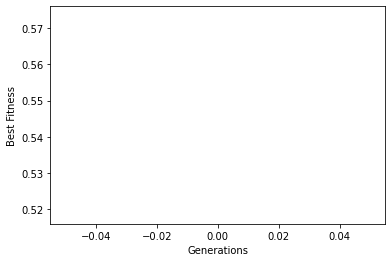

157/157 - 1s - loss: 1.8726 - accuracy: 0.3318
157/157 - 0s - loss: 1.8911 - accuracy: 0.3212


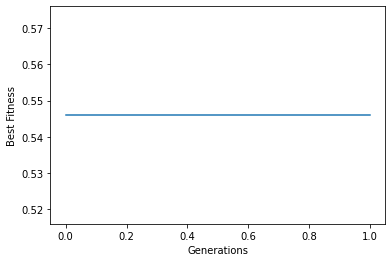

157/157 - 0s - loss: 1.0661 - accuracy: 0.6318


In [ ]:
best_gene, best_is_active, fitnesses = evolution(gene, is_active, 50, 0.05)

In [ ]:
plt.plot(fitnesses)
plt.xlabel('Generations')
plt.ylabel('Best Fitness')
plt.savefig('cols50_levelsback10_mutationrate05_run1.png')
plt.show()
print(fitnesses[-1])

In [ ]:
best_network = genotype_to_cnn(best_gene, best_is_active)

In [ ]:
# check if correct network is returned
#train_single_network(best_network)

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(best_network, to_file='cols50_levelsback10_mutationrate05_run1_network.png')

In [ ]:
# train last/best network and test
best_network = genotype_to_cnn(best_gene, best_is_active)
print(best_network.summary())
best_network.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
hist = best_network.fit(x_train_full,
                        y_train_full, 
                        batch_size=128, 
                        epochs=100)
best_network.evaluate(x_test, y_test)